# Aula 02 - FAST.AI: Bears

## Gathering Data

### Import inicial

In [47]:
from fastbook import *

### Função base de busca 'ddg'

In [6]:
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

### Busca por 'grizzly bear'

In [13]:
ims = search_images_ddg('grizzly bear', max_images=260)
len(ims)

260

### Download de uma imagem encontrada

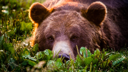

In [23]:
dest = 'images/grizzly.jpg'
download_url(ims[2], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(128,128)

### Download de várias imagens

In [19]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} bear')
        download_images(dest, urls=results)

### Checando diretórios

In [22]:
fns = get_image_files(path)
fns

(#559) [Path('bears/black/007e839e-44d1-4627-951e-25b9b0ef59f7.jpg'),Path('bears/black/00e3d8d8-7db9-4dca-af2e-69ce92276a55.jpg'),Path('bears/black/069316fc-15ae-4f4c-9078-1f2cc7328e49.jpg'),Path('bears/black/06c2ce37-5dd9-4889-971b-11f25c0d79ca.jpg'),Path('bears/black/07c71e96-ea6c-487b-8b72-51077c41205a.jpg'),Path('bears/black/08a2c154-bf67-4d7d-8cde-014c32170836.jpg'),Path('bears/black/08ecee8a-125e-4f4b-9da7-691a93e0db1b.jpg'),Path('bears/black/0c0f15e0-4621-4332-8407-0dbd6d16f403.jpg'),Path('bears/black/0cf7188a-ea9f-4a88-9223-ecbd0b040822.jpg'),Path('bears/black/0ec8b5bd-c5dd-4baa-96c3-577d5bd32f46.jpg')...]

### Checando se há imagens corrompidas

In [24]:
failed = verify_images(fns)
len(failed)

24

### Removendo imagens corrompidas

In [25]:
failed.map(Path.unlink)

(#24) [None,None,None,None,None,None,None,None,None,None...]

## Sidebar: Getting Help in Jupyter Notebooks

In [28]:
?verify_images

In [29]:
doc(verify_images)

verify_images(fns)
Find images in `fns` that can't be opened

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


## Cleaning the data

In [30]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [31]:
dls = bears.dataloaders(path)

### Visualizando uma amostra das imagens do banco com as identificações(categorias)

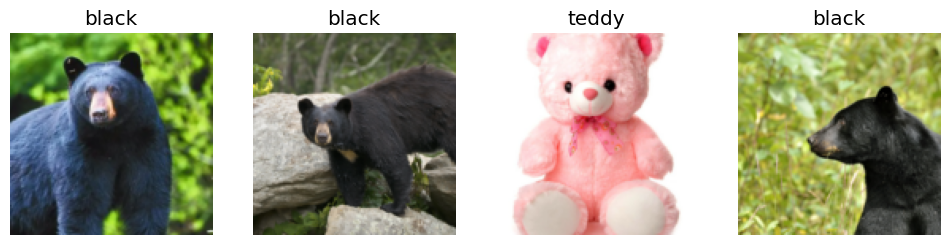

In [32]:
dls.valid.show_batch(max_n=4, nrows=1)

### Resize - testando tipos diferentes

#### SQUISH

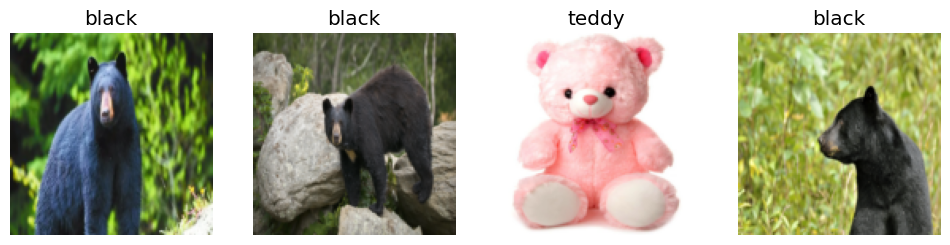

In [33]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

#### PAD

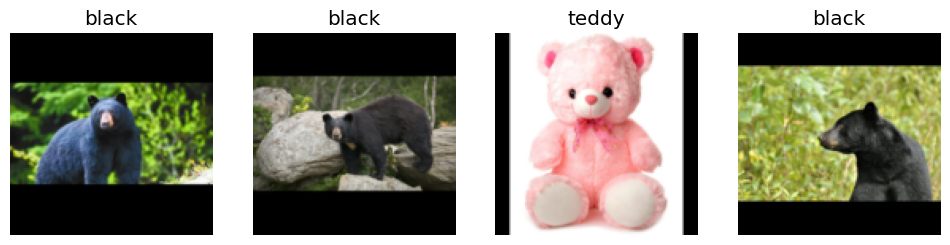

In [34]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

#### CROP

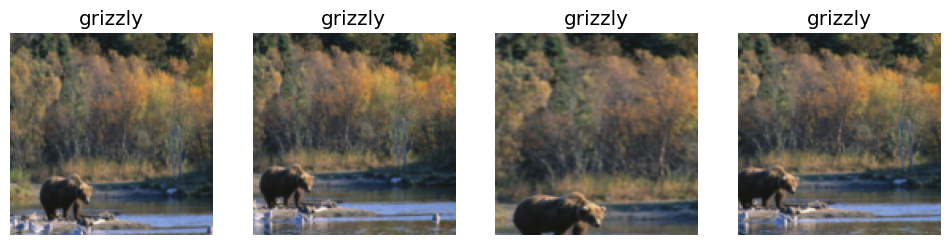

In [35]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Data Augmentation

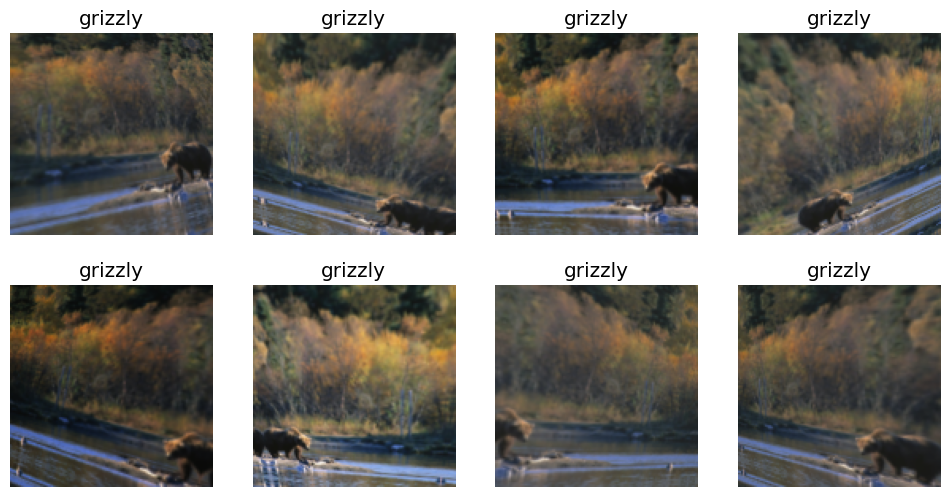

In [36]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Treinando o modelo e usando-o para limpar os dados

In [37]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [38]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

C:\Users\keng\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\keng\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.219775,0.082200,0.028037,00:35


epoch,train_loss,valid_loss,error_rate,time
0,0.289683,0.053070,0.018692,00:42
1,0.208650,0.069925,0.028037,00:42
2,0.181531,0.094069,0.037383,00:41
3,0.150588,0.092083,0.028037,00:39


### Matriz de confusão

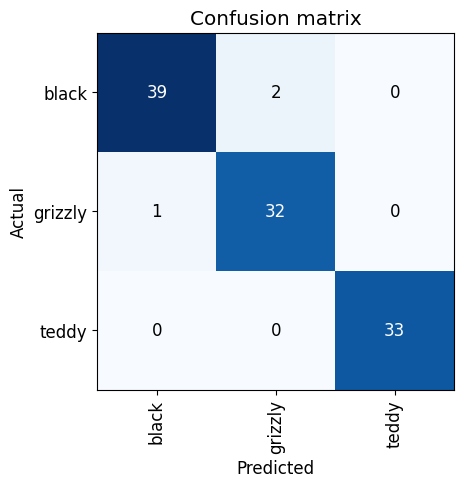

In [39]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Avaliando maiores perdas (losses)

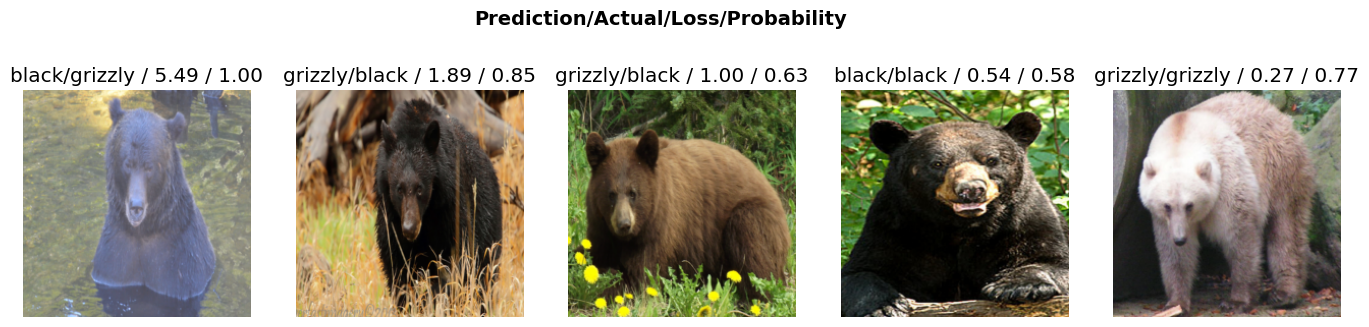

In [40]:
interp.plot_top_losses(5, nrows=1, figsize=(17,4))

### Limpando as imagens/categorias

In [51]:
cleaner = ImageClassifierCleaner(learn)
cleaner

### Aplicando a limpeza selecionada anteriormente

In [42]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Retreinando o modelo e usando-o para limpar os dados

In [48]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [49]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.103325,0.302904,0.130841,00:33


epoch,train_loss,valid_loss,error_rate,time
0,0.207713,0.056906,0.018692,00:43
1,0.181648,0.074105,0.018692,00:40
2,0.159975,0.067882,0.028037,00:40
3,0.130746,0.075618,0.028037,00:39


### Matriz de confusão

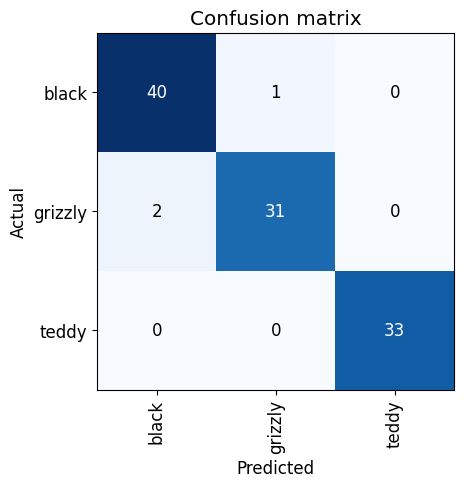

In [50]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()